<code>plot_RMSE_all_days_ALL_YEAR.ipynb</code> plots RMSE as a function of lead time for ALL DAYS for all S2S models.

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from S2S_sea_ice_plotting import RMSE_plot

### Inputs:
* <code>model_names</code>: which models to include (helpful for debugging)
* <code>seas_str</code>: which season to plot (string) (for this notebook, we'll just do ALL)
* <code>seas_sel</code>: months to include (array) (all months for this notebook)
* <code>vrile_thresh</code>: threshold for VRILE calculation (string)
* <code>clim_freq</code>: lead time in days or weeks (string)
* <code>TO_PLOT</code>: are we plotting SIE or SIE anom?
* <code>obs_name</code>: which set of obs to use (string)
* <code>obs_name_plt</code>: name of obs (for plot, string)
* <code>ALL_DAYS</code>: boolean; if true, include VRILE and nonVRILE days; if false, just use nonVRILE days

In [2]:
ALL_REGIONS = False 
model_names = ['ecmwf','ukmo','ncep','metreofr','DAMPED_ANOMALY']
#model_names = ['DAMPED_ANOMALY']
seas_str = 'ALL'
seas_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
vrile_thresh = '05'
clim_freq = 'WEEKLY'
TO_PLOT = 'SIE anom RMSE'
obs_name = 'NSIDC_0079'
obs_name_plt = 'NASA Bootstrap'
ALL_DAYS = True

### Steps
1. Load on RMSE spreadsheets for all days and VRILE days, and combine all models into one spreadsheet 
2. Plot RMSE vs lead time for specified season for desired regions. 

Load <code>.csv</code> files

In [3]:
d_SIE_all = pd.DataFrame()
fpath_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/'
for i_model in model_names:
    # Damped anomaly has different filename
    # if (i_model == 'DAMPED_ANOMALY') & (obs_name == 'NSIDC_0051'):
    if (i_model == 'DAMPED_ANOMALY') & (obs_name == 'NSIDC_0051'):
        fpath = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/DAMPED_ANOMALY/OBS_{obs_name}/'.format(obs_name=obs_name)
        fpath_all = fpath+'lead_time_WEEKS/VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}_WITH_LOO.csv'.format(model_name=i_model,
                                                                                            seas_str=seas_str,
                                                                                            vrile_thresh=vrile_thresh,
                                                                                            clim_freq=clim_freq)
        d_SIE = pd.read_csv(fpath_all)
        d_SIE['Model Name'] = 'Damped Anomaly'
        d_SIE_all = d_SIE_all.append(d_SIE)
    elif (i_model == 'DAMPED_ANOMALY') & (obs_name == 'NSIDC_0079'):
        fpath_all = fpath_load+'{model_name}_{obs_name}/OBS_{obs_name}/'.format(model_name=i_model,obs_name=obs_name)       
        fpath_all = fpath_all+'COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_{obs_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                obs_name=obs_name,seas_str=seas_str,
                                                                                            vrile_thresh=vrile_thresh,
                                                                                           clim_freq=clim_freq)
        d_SIE = pd.read_csv(fpath_all)
        d_SIE['Model Name'] = 'Damped Anomaly'
        d_SIE_all = d_SIE_all.append(d_SIE)
        
    else:
        # Load ALL DAYS
        fpath_all = fpath_load+'{model_name}/OBS_{obs_name}/COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                                obs_name=obs_name,
                                                                                                seas_str=seas_str,
                                                                                                vrile_thresh=vrile_thresh,
                                                                                                clim_freq=clim_freq)
        d_SIE = pd.read_csv(fpath_all)
        # Because we spelled "meteofr" wrong
        if i_model == 'metreofr':
            d_SIE['Model Name'] = 'meteofr'
        else:
            d_SIE['Model Name'] = i_model
        # 
        d_SIE_all = d_SIE_all.append(d_SIE)
        
    

In [4]:
#McGraw_etal_2020/code/make_it_nice/data/DAMPED_ANOMALY/OBS_NSIDC_0051/lead_time_WEEKS/VRILE_vs_NOVRILE_RMSE_MAE_DAMPED_ANOMALY_monthsALL_VRILE05_model_clim_freq_WEEKLY_WITH_LOO.csv

In [5]:
fpath_all

'/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/DAMPED_ANOMALY_NSIDC_0079/OBS_NSIDC_0079/COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_DAMPED_ANOMALY_NSIDC_0079_monthsALL_VRILE05_model_clim_freq_WEEKLY.csv'

Trim regions

In [6]:
regions_all = d_SIE_all['region'].unique().tolist()
regions_drop = ['St John']#,'Hudson Bay','Canadian Islands','Bering','Sea of Okhotsk']
regions_sel = d_SIE_all[~d_SIE_all['region'].isin(regions_drop)]['region'].unique().tolist()
if ALL_REGIONS == True:
    regions_list = regions_sel
    ncols = 5
    reg_save_str = 'REG_ALL'
    fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/'
    ftype = 'pdf'
else:
    regions_list = ['panArctic','Barents Sea','East Greenland Sea','Central Arctic','Kara-Laptev Sea',
                     'East Siberian-Beaufort-Chukchi Sea','Bering']
    ncols = 2
    reg_save_str = 'REG_TRIM'
    fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/'
    ftype='pdf'
if not os.path.exists(fpath_save):
    os.makedirs(fpath_save)

In [7]:
d_SIE_all = d_SIE_all[~d_SIE_all['region'].isin(regions_drop)]

Shorten region names and replace to plot in desired order

In [8]:
d_SIE_all['region'] = d_SIE_all['region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
#model_R2_select['Model Name'] = model_R2_select['Model Name'].replace({'metreofr':'meteofr'})
#
d_SIE_all['Model Name'] = d_SIE_all['Model Name'].replace({'ecmwf':'ECMWF','ukmo':'UKMO','meteofr':'METEOFR',
                                                          'ncep':'NCEP'})
regions_sort = ["panArctic","Central Arctic","E. Sib./Beauf./Chuk. Sea","Kara-Laptev Sea",
                "Barents Sea","E. Greenland Sea","Bering"]
d_SIE_all['region sort'] = pd.Categorical(d_SIE_all['region'],regions_sort)


Group by region, lead day, model, and type (all days or non-VRILE days only, based on <code>ALL_DAYS</code>)

In [17]:
if ALL_DAYS == False:
    d_SIE_all_gb = d_SIE_all.groupby(['region sort','Model Name','type','lead days']).mean()
    d_SIE_all_gb = d_SIE_all_gb.xs(('no VRILE days'),level=2)
elif ALL_DAYS == True:
    d_SIE_all_gb = d_SIE_all.groupby(['region sort','Model Name','lead days']).mean()

   # d_SIE_all_gb = d_SIE_all_gb.mean(level=(0,1,3))


In [18]:
if TO_PLOT == 'SIE RMSE':
    title_str = 'Sea Ice Extent'
    save_str = 'SIE'
else:
    title_str = 'Anomalous Sea Ice Extent'
    save_str = 'SIE_anom'

Plot

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/ALL_DAYS_SIE_anom_ALL_RMSE_only_NSIDC_0079.png


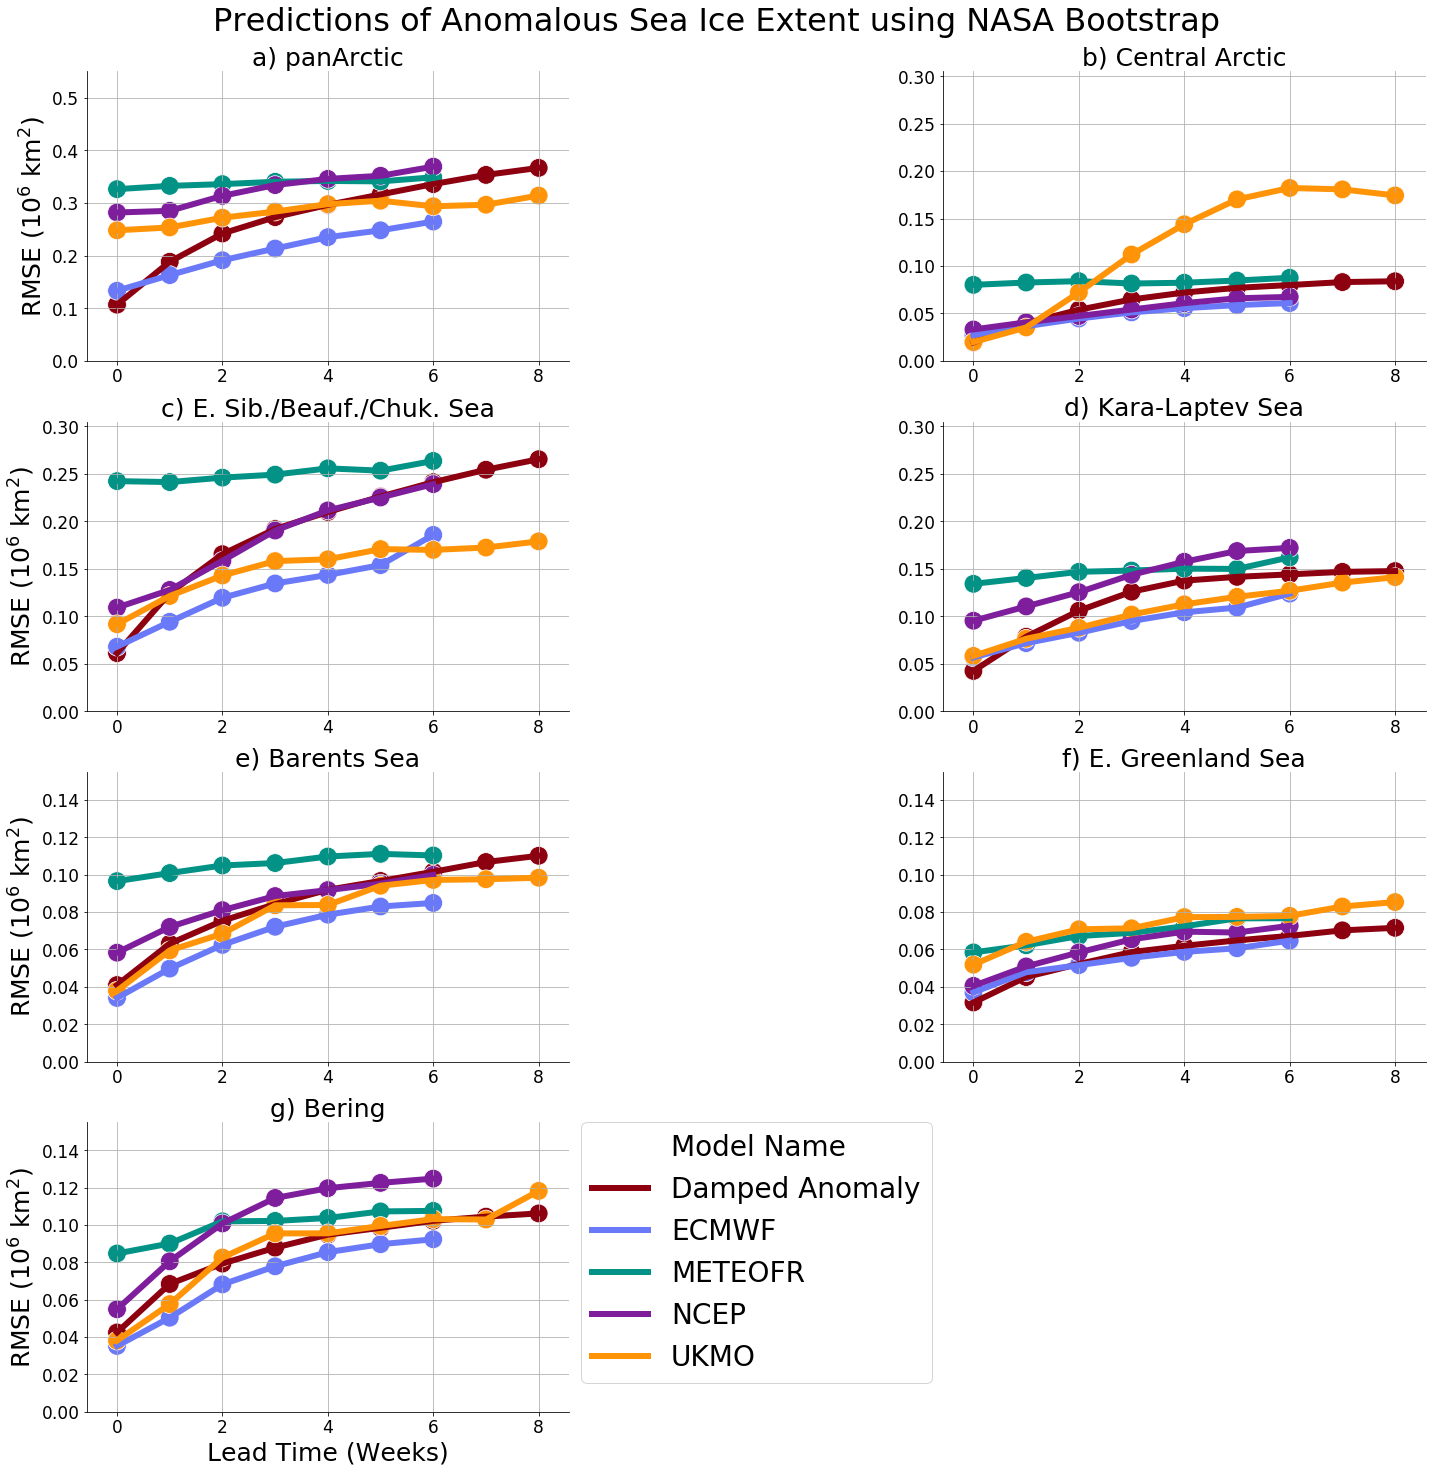

In [19]:
nrows = 4
ncols = 2
no_regions = len(regions_sort)
if TO_PLOT == 'SIE RMSE':
    vmax = [1.05,0.75,0.75,0.375,0.255,0.375,0.255]
else:
    vmax = [0.550,0.305,0.305,0.305,0.155,0.155,0.155]
vmin = 0
fig1,ax1 = plt.subplots(nrows,ncols,figsize=(20,20))
for i in range(0,no_regions):
    ax_sel = ax1.flat[i]
    #i_reg = np.floor(i/2).astype(int)
    i_reg = i
    reg_sel = regions_sort[i_reg]
    #if np.mod(i,2) == 0:
    data_sel = d_SIE_all_gb.xs((reg_sel)).reset_index()
    #elif np.mod(i,2) == 1:
     #   data_sel = d_SIE_all_gb2.xs((reg_sel)).reset_index()
    # Plot
    RMSE_plot(ax_sel,data_sel,reg_sel,TO_PLOT,i,vmin,vmax[i_reg],no_regions,ncols,nrows)
    #if i == len(no_regions):
    #ax_sel.legend(bbox_to_anchor=(1.025,1),loc=2,borderaxespad=0,fontsize=18)
fig1.delaxes(ax=ax1.flat[7])        
fig1.tight_layout()

if TO_PLOT == 'SIE RMSE':
    fig1.suptitle('Predictions of Sea Ice Extent using {obs_name}'.format(obs_name=obs_name_plt),fontsize=32,y=1.02)
else:
    fig1.suptitle('Predictions of Anomalous Sea Ice Extent using {obs_name}'.format(obs_name=obs_name_plt),fontsize=32,y=1.02)
if ALL_DAYS == True:
    fpath_save1 = fpath_save+'ALL_DAYS_{save_str}_{seas_str}_RMSE_only_{obs_name}.png'.format(save_str=save_str,seas_str=seas_str,
                                                                                   obs_name=obs_name)
elif ALL_DAYS == False:
    fpath_save1 = fpath_save+'noVRILE_DAYS_{save_str}_{seas_str}_RMSE_only_{obs_name}.png'.format(save_str=save_str,seas_str=seas_str,
                                                                                   obs_name=obs_name)
fig1.savefig(fpath_save1,format='png',dpi=350,bbox_inches='tight')  
print(fpath_save1)

In [12]:
d_SIE_all_gb.xs('E. Sib./Beauf./Chuk. Sea')

SIE RMSE   SIE MAE  year out  SIE sdev  \
Model Name     lead days                                           
Damped Anomaly 0.0        0.058607  0.040935    2006.5  0.548460   
               1.0        0.128254  0.090315    2006.5  0.525532   
               2.0        0.179211  0.124496    2006.5  0.503285   
               3.0        0.212435  0.145634    2006.5  0.489196   
               4.0        0.233880  0.159701    2006.5  0.478943   
               5.0        0.252343  0.172169    2006.5  0.467841   
               6.0        0.268859  0.183762    2006.5  0.458935   
               7.0        0.280867  0.190795    2006.5  0.452158   
               8.0        0.289384  0.194724    2006.5  0.448410   
ECMWF          0.0        0.185755  0.151656    2006.5  0.582627   
               1.0        0.186387  0.141968    2006.5  0.573144   
               2.0        0.177696  0.128560    2006.5  0.551264   
               3.0        0.175873  0.115118    2006.5  0.530141   
               4.0        0.175642  0.113150    2006.5  0.516993   
               5.0        0.191540  0.125144    2006.5  0.502635   
               6.0        0.655491  0.430891    2006.5  1.023744   
               7.0             NaN       NaN       NaN       NaN   
               8.0             NaN       NaN       NaN       NaN   
METEOFR        0.0        0.479317  0.352111    2006.5  0.329827   
               1.0        0.478803  0.349278    2006.5  0.320324   
               2.0        0.478227  0.348552    2006.5  0.318491   
               3.0        0.470527  0.340441    2006.5  0.321692   
               4.0        0.461432  0.328585    2006.5  0.322295   
               5.0        0.444145  0.314273    2006.5  0.324576   
               6.0        0.928102  0.569961    2006.5  0.883725   
               7.0             NaN       NaN       NaN       NaN   
               8.0             NaN       NaN       NaN       NaN   
NCEP           0.0        0.173618  0.121690    2006.5  0.525515   
               1.0        0.248547  0.179667    2006.5  0.503949   
               2.0        0.317849  0.239033    2006.5  0.458969   
               3.0        0.374289  0.280349    2006.5  0.402538   
               4.0        0.405365  0.294234    2006.5  0.363303   
               5.0        0.413644  0.292365    2006.5  0.343688   
               6.0        0.746386  0.687212    2006.5  1.192812   
               7.0             NaN       NaN       NaN       NaN   
               8.0             NaN       NaN       NaN       NaN   
UKMO           0.0        0.116021  0.079681    2006.5  0.589693   
               1.0        0.216536  0.157235    2006.5  0.613892   
               2.0        0.281893  0.212361    2006.5  0.635079   
               3.0        0.303739  0.225327    2006.5  0.666563   
               4.0        0.305851  0.219789    2006.5  0.677307   
               5.0        0.300844  0.203051    2006.5  0.698378   
               6.0        0.292222  0.193361    2006.5  0.704473   
               7.0        0.271085  0.177303    2006.5  0.688072   
               8.0        0.270823  0.172858    2006.5  0.672897   

                           sample size     p-value  SIE anom RMSE  \
Model Name     lead days                                            
Damped Anomaly 0.0        2.939903e+06   49.771025       0.061167   
               1.0        2.939903e+06  128.248733       0.124426   
               2.0        2.939903e+06  199.210176       0.165426   
               3.0        2.939903e+06  241.298600       0.191916   
               4.0        2.939903e+06  258.239761       0.209936   
               5.0        2.939903e+06  276.315828       0.226106   
               6.0        2.939903e+06  289.734046       0.241264   
               7.0        2.939903e+06  287.062484       0.254401   
               8.0        2.939903e+06  280.802695       0.265474   
ECMWF          0.0        6.569055e+05   60.584474       0.067971   
 